In [1]:
# Load swiss temperature data

import pandas as pd
import glob

path = "data/swiss"
filenames = glob.glob(path + "/*.txt")
dfs = []
N = len(filenames)
for filename in filenames:
    with open(filename, encoding="Windows-1252") as f:
        content = f.readlines()
        station = content[5].split(None, 1)[1][:-1]
        altitude = float(content[6].split()[3])
        latitude = int(content[7].split()[1][:-1]) + float(content[7].split()[2][:-1]) / 60
        longitude = int(content[7].split()[5][:-1]) + float(content[7].split()[6][:-1]) / 60
    df = pd.read_table(
        filename,
        encoding="Windows-1252",
        delim_whitespace=True,
        skiprows=27,
    )
    df["Station"] = station
    df["Altitude"] = altitude
    df["Latitude"] = latitude
    df["Longitude"] = longitude
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all.head()


,Year,Month,Temperature,Precipitation,Station,Altitude,Latitude,Longitude
0,1864,1,-4.5,40.8,Altdorf,438.0,46.886667,8.621667
1,1864,2,-0.4,38.0,Altdorf,438.0,46.886667,8.621667
2,1864,3,5.4,31.6,Altdorf,438.0,46.886667,8.621667
3,1864,4,7.2,155.1,Altdorf,438.0,46.886667,8.621667
4,1864,5,12.6,103.9,Altdorf,438.0,46.886667,8.621667


C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_30796\2493413670.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_1965_1989_january = data_1965_1989[df_all["Month"] == 1].groupby("Station")
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_30796\2493413670.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_1965_1989_july = data_1965_1989[df_all["Month"] == 7].groupby("Station")


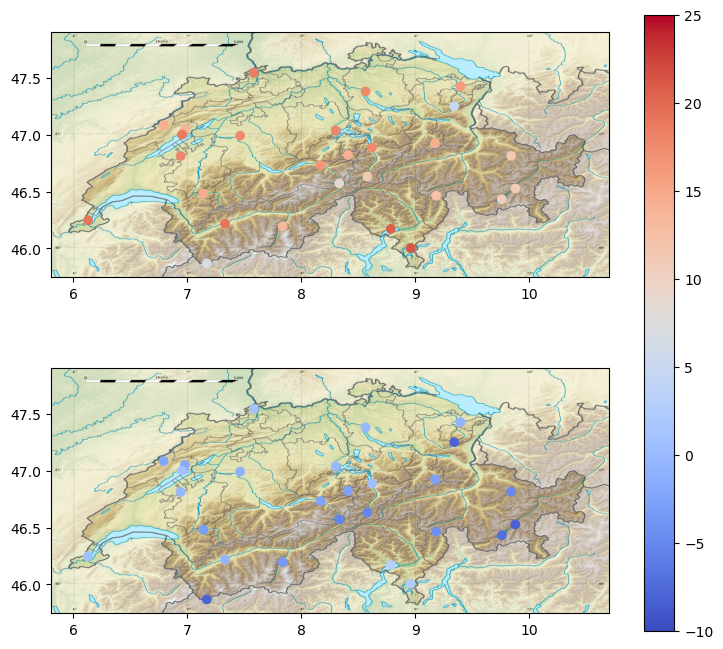

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

data_1965_1989 = df_all[(df_all["Year"] >= 1965) & (df_all["Year"] < 1990)]
data_1965_1989_january = data_1965_1989[df_all["Month"] == 1].groupby("Station")
data_1965_1989_july = data_1965_1989[df_all["Month"] == 7].groupby("Station")

img = plt.imread("data/swiss/Switzerland_relief_location_map.jpg")
plt.figure(figsize=(9, 8))
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9])
ax1.scatter(data_1965_1989_july.mean()["Longitude"], data_1965_1989_july.mean()["Latitude"], c=data_1965_1989_july.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)

ax2 = plt.subplot(2, 1, 2)
ax2.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9])
im = ax2.scatter(data_1965_1989_january.mean()["Longitude"], data_1965_1989_january.mean()["Latitude"], c=data_1965_1989_january.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)
plt.colorbar(im, ax=[ax1, ax2])
plt.show()


(CVXPY) Dec 07 10:40:50 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
0
(27, 25)
1
(27, 25)
2
(27, 25)
3
(27, 25)
4
(27, 25)
5
(27, 25)
6
(27, 25)
7
(27, 25)
8
(27, 25)
9
(27, 25)
10
(27, 25)
11
(27, 25)
12
(27, 25)
13
(27, 25)
14
(27, 25)
15
(27, 25)
16
(27, 25)
17
(27, 25)
18
(27, 25)
19
(27, 25)
0
(27, 25)
1
(27, 25)
2
(27, 25)
3
(27, 25)
4
(27, 25)
5
(27, 25)
6
(27, 25)
7
(27, 25)
8
(27, 25)
9
(27, 25)
10
(27, 25)
11
(27, 25)
12
(27, 25)
13
(27, 25)
14
(27, 25)
15
(27, 25)
16
(27, 25)
17
(27, 25)
18
(27, 25)
19
(27, 25)
[[-1.03526143e-01 -7.88005214e-11 -1.61406594e-01  2.20873416e-01
   1.06709565e-09 -1.54899985e-09 -4.47392159e-09 -8.55097178e-11
  -1.55569373e-09 -1.54525757e-09 -2.69626723e-01 -4.96848770e-09
  -1.08387129e-09 -1.53703527e-09  8.60772937e-10  5.15644648e-09
   8.47748732e-02  1.76580967e-01 -1.91995815e-01  1.46817072e-01
  -2.53326800e-09 -1.35120316e-

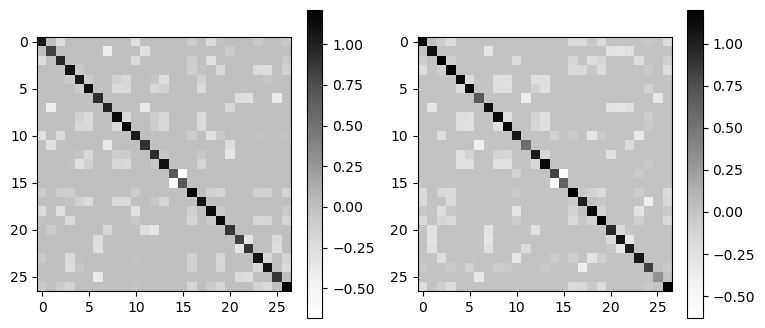

In [3]:
import cvxpy as cp
import numpy as np

def topo_infer_smooth(data, N, alpha, beta, iter, tr=None):
    M = data.shape[1] if data.ndim == 2 else 1
    if M == 1:
        data = data.reshape(-1, 1)
    if tr is None:
        tr = N
    y = cp.Variable((N, M))
    y_0 = data
    Lap = cp.Variable((N, N), PSD=True)

    for cnt in range(iter):
        print(cnt)
        constraints = [Lap @ np.ones((N,)) == np.zeros((N,)), Lap - cp.diag(cp.diag(Lap)) <= 0, cp.trace(Lap) == tr]
        print(y_0.shape)
        objective = cp.Minimize(alpha * cp.trace(cp.quad_form(y_0, Lap)) + beta * cp.norm(Lap, "fro") ** 2)
        prob = cp.Problem(objective, constraints)
        prob.solve()
        Lap_0 = Lap.value
        Lap_0 = Lap_0 - np.eye(N) * np.min(np.linalg.eigvals(Lap_0))
        objective2 = cp.Minimize(cp.norm(y - data, "fro") ** 2 + alpha * cp.sum([cp.quad_form(y[:, i], Lap_0) for i in range(M)]))
        prob2 = cp.Problem(objective2)
        prob2.solve()
        y_0 = y.value
    
    return Lap_0

t_january = np.array(data_1965_1989_january["Temperature"].apply(lambda x: np.array(x.values.tolist())).to_list()) # 27x25
t_july = np.array(data_1965_1989_july["Temperature"].apply(lambda x: np.array(x.values.tolist())).to_list())

alpha = 0.01
beta = 0.5
Lap_0_january = topo_infer_smooth(t_january, N, alpha, beta, 20)
Lap_0_july = topo_infer_smooth(t_july, N, alpha, beta, 20)
print(Lap_0_january - Lap_0_july)

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.imshow(Lap_0_january, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(Lap_0_july, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.show()


C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_30796\3910171463.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  longitudes = [df_all[df_all.eq(station_name).any(1)]["Longitude"].values[0] for station_name in stations]
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_30796\3910171463.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  latitudes = [df_all[df_all.eq(station_name).any(1)]["Latitude"].values[0] for station_name in stations]
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_30796\3910171463.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  altitudes = np.array([df_all[df_all.eq(station_name).any(1)]["Altitude"].values[0] for station_name in stations])


0
(27, 1)
1
(27, 1)
2
(27, 1)
3
(27, 1)
4
(27, 1)
5
(27, 1)
6
(27, 1)
7
(27, 1)
8
(27, 1)
9
(27, 1)
10
(27, 1)
11
(27, 1)
12
(27, 1)
13
(27, 1)
14
(27, 1)
15
(27, 1)
16
(27, 1)
17
(27, 1)
18
(27, 1)
19
(27, 1)


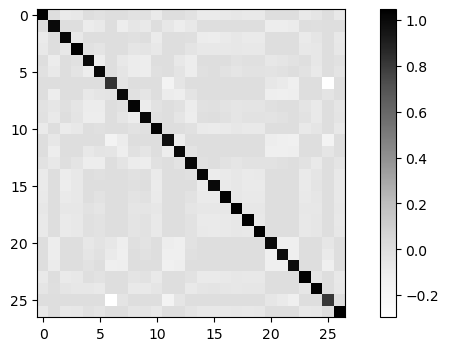

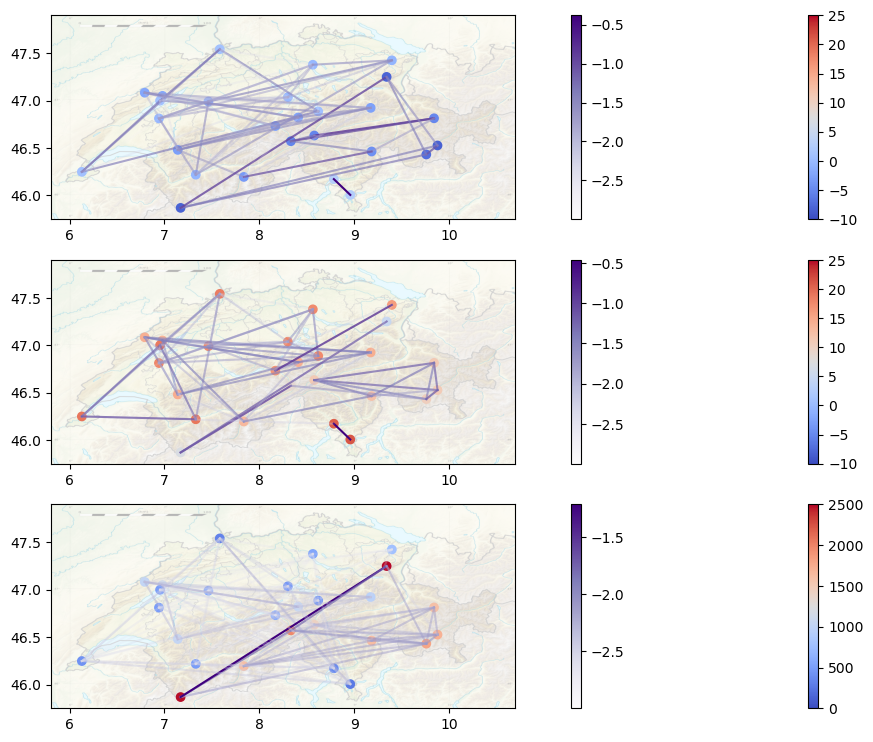

In [4]:
stations = data_1965_1989_january.mean()["Temperature"].keys()
longitudes = [df_all[df_all.eq(station_name).any(1)]["Longitude"].values[0] for station_name in stations]
latitudes = [df_all[df_all.eq(station_name).any(1)]["Latitude"].values[0] for station_name in stations]
altitudes = np.array([df_all[df_all.eq(station_name).any(1)]["Altitude"].values[0] for station_name in stations])

Lap_0_altitude = topo_infer_smooth(altitudes / 200, N, 0.01, 0.3, 20)
plt.figure(figsize=(9, 4))
plt.imshow(Lap_0_altitude, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.show()

def plot_graph(ax, data, Lap, N, th, img, vmin=-10, vmax=25):
    ax.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9], alpha=0.3)
    z = ax.scatter(longitudes, latitudes, c=data, cmap="coolwarm", vmin=vmin, vmax=vmax)
    plt.colorbar(z, ax=ax)

    color_norm = mpl.colors.Normalize(vmin=np.log(th), vmax=np.log(np.max(-Lap)))
    cmap = cm.Purples
    color_map = cm.ScalarMappable(norm=color_norm, cmap=cmap)
    for i in range(N):
        for j in range(i+1, N):
            if Lap[i, j] < -th:
                ax.plot([longitudes[i], longitudes[j]], [latitudes[i], latitudes[j]], c=color_map.to_rgba(np.log(-Lap[i, j])), alpha=color_norm(np.log(-Lap[i, j])))
    plt.colorbar(color_map)

plt.figure(figsize=(18, 9))
ax1 = plt.subplot(3, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], Lap_0_january, N, 0.05, img)

ax2 = plt.subplot(3, 1, 2)
plot_graph(ax2, data_1965_1989_july.mean()["Temperature"], Lap_0_july, N, 0.05, img)

ax3 = plt.subplot(3, 1, 3)
plot_graph(ax3, altitudes, Lap_0_altitude, N, 0.05, img, vmin=0, vmax=2500)

plt.show()

0
[-1.00000000e+00  1.30499123e+01  5.19495810e+00  3.46587097e-01
  0.00000000e+00 -1.55336430e+00  2.06070091e+00 -3.75884840e+00
 -1.52196412e+00 -5.40504642e-01 -7.99940544e-01  8.16175778e-03
 -0.00000000e+00 -1.68165057e+00  7.53897743e-02 -1.75927000e-01
 -1.25634487e+00 -1.51465048e+00 -7.25650835e-01 -1.04697493e+00
  5.05101742e-01 -2.23189193e+00 -0.00000000e+00 -1.57629208e+00
 -7.60729591e-01 -7.44458855e-01 -9.69978048e-01]
[-25.27827808  -1.         -28.35228237  18.69743425  11.22934337
   2.48673166   8.87050686 -15.12379521  -6.26414147  -0.
   0.71025276   0.07414303   3.10622219   1.52203682  -1.3479294
  -5.51034039  -0.62299788   0.45276543  -5.50356153  -2.29456054
   7.89018139  -6.54800983  -0.26944463  -1.99637064  -0.49177733
  -3.99667885   0.92324647]
[-1.40542971e+04 -4.47275509e+05 -1.00000000e+00 -2.07436632e+06
  1.78138691e+06  1.57840909e+06  9.60502660e+05 -2.16109978e+06
 -1.20396493e+06  1.39411746e+04  6.55680312e+05 -7.06744512e+05
  7.40879427e+

C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_30796\3129147947.py:44: RuntimeWarning: overflow encountered in matmul
  Q[j, j] = 1.0 / (W_new[j, j] - W_new[index, j].T @ beta[index] + eps)
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_30796\3129147947.py:44: RuntimeWarning: invalid value encountered in matmul
  Q[j, j] = 1.0 / (W_new[j, j] - W_new[index, j].T @ beta[index] + eps)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[

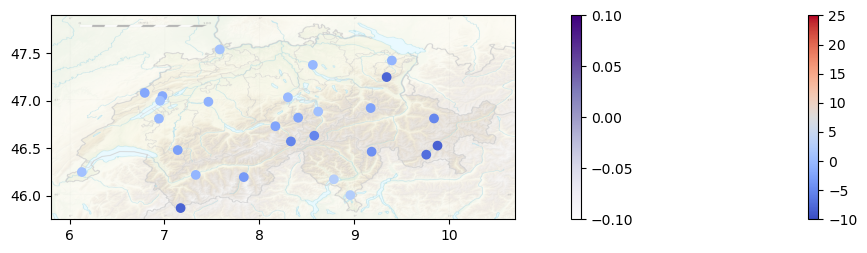

In [78]:
from sklearn.covariance import GraphicalLasso, graphical_lasso

def soft_threshold(x, l):
    return np.sign(x) * np.maximum(0, np.abs(x) - l)

def topo_infer_glasso(data, N, l, iter=20, tol=1e-6, eps=1e-3):
    M = data.shape[1] if data.ndim == 2 else 1
    if M == 1:
        data = data.reshape(-1, 1)
    # data is N x M
    S = np.cov(data)
    W = S + l * np.eye(N) # Initialize the inverse of precision matrix
    W_new = np.copy(W)
    # print(W)
    Q = np.copy(S) # Initialize the precision matrix

    for cnt in range(iter):
        print(cnt)
        # Solve for the precision matrix estimate
        for j in range(N):
            index = np.arange(N) != j

            # Solve the modified Lasso problem
            beta = -Q[:, j] / Q[j, j]
            beta_new = np.copy(beta)
            for cnt2 in range(iter):
                for k in np.arange(N)[index]:
                    index2 = np.logical_and(np.arange(N) != k, index)
                    beta_new[k] = soft_threshold(S[k, j] - beta_new[index2].T @ W_new[index2, k], l) / W_new[k, k]
                    # print(W[index, k])
                if np.linalg.norm(beta_new - beta) < tol:
                    break
                beta = beta_new
            
            print(beta)
            # Update the inverse of precision matrix
            W_new[j, index] = -W_new[np.ix_(index, index)] @ beta[index].reshape(-1)
            # print(beta[index])
            W_new[index, j] = W_new[j, index].T
            # if np.any(np.isnan(W_new)):
            #     print(W_new)

            # Update the precision matrix
            Q[j, j] = 1.0 / (W_new[j, j] - W_new[index, j].T @ beta[index] + eps)
            Q[j, index] = -Q[j, j] * beta[index].reshape(-1)
            Q[index, j] = Q[j, index].T

        # for j in range(W.shape[0]):
        #     for k in range(W.shape[1]):
        #         if j == k:
        #             # Compute the diagonal element of the precision matrix
        #             W_new[j, k] = S[j, j] - S[j, :] @ np.linalg.inv(C[:, :] + np.eye(W.shape[0])/l) @ S[:, j]
        #         else:
        #             # Compute the off-diagonal element of the precision matrix
        #             W_new[j, k] = -S[j, :] @ np.linalg.inv(C[:, :] + np.eye(W.shape[0])/l) @ S[:, k]
        # Check for convergence
        if np.linalg.norm(W_new - W) < tol:
            break
        W = W_new
    
    return Q

def graphical_lasso_test(S, alpha, tol=1e-6, max_iter=100, init=None):
    # Initialize the precision matrix
    if init is None:
        # Use the Ledoit-Wolf estimator to initialize the precision matrix
        W = np.linalg.inv(np.cov(S.T))
    else:
        W = init

    # Iterate until convergence
    for i in range(max_iter):
        prev_W = W.copy()

        # Iterate over each element of the precision matrix
        for j in range(S.shape[1]):
            for k in range(S.shape[1]):
                if j == k:
                    continue

                # Compute the updated value of w_jk using the optimization problem
                w_jk = (S[j, k] - np.dot(W[j, :], S[:, k])) / (1 - np.dot(W[j, :], W[:, k]))
                w_jk += alpha * np.sign(W[j, k])

                # Update the precision matrix
                W[j, k] = w_jk

        # Check for convergence
        if np.abs(W - prev_W).max() < tol:
            break

    return W

Lap_0_january_lasso = topo_infer_glasso(t_january, N, 0.5)
#estimator = GraphicalLasso(alpha=0.5)
# Lap_0_january_lasso = estimator.fit(np.cov(t_january)).precision_
# Lap_0_january_lasso = graphical_lasso(np.cov(t_january), 0.5, return_costs=False)[1]
# Lap_0_january_lasso_test = graphical_lasso_test(np.cov(t_january), 0.5)
#print(np.minimum(Lap_0_january_lasso_test, 0))
plt.figure(figsize=(18, 9))
ax1 = plt.subplot(3, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], np.minimum(Lap_0_january_lasso, 0), N, 0.1, img)


C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_4588\1497127798.py:9: RuntimeWarning: divide by zero encountered in divide
  G = nx.from_numpy_matrix(1 / A)


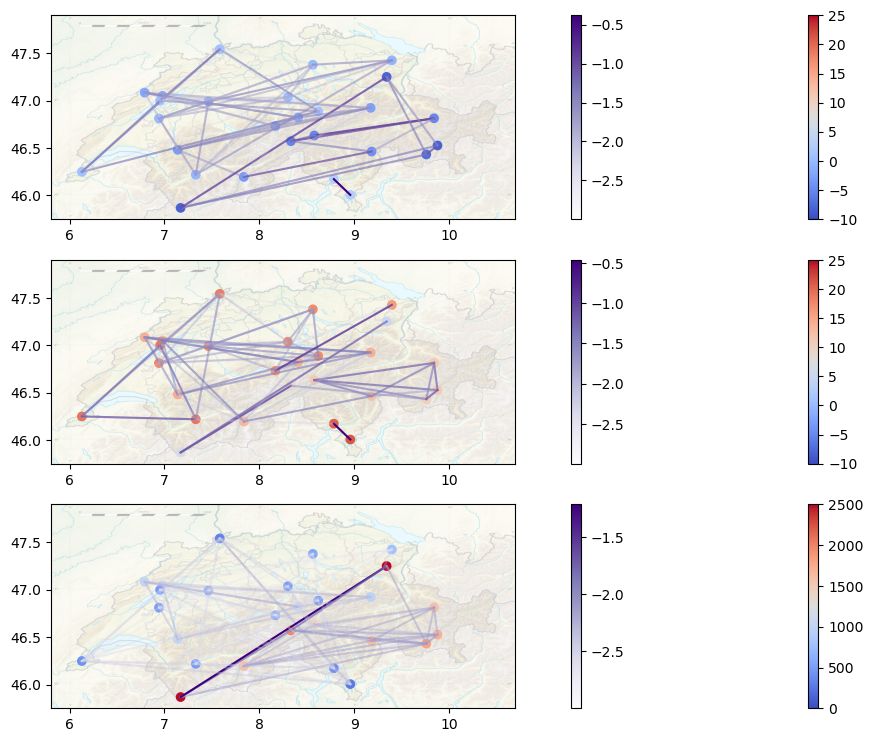

In [5]:
import networkx as nx

def graph_sparsify(Lap):
    N = Lap.shape[0]
    Lap_0 = Lap.copy()
    A = -Lap_0
    np.fill_diagonal(A, 0)
    A[A < 1e-10] = 0
    G = nx.from_numpy_matrix(1 / A)
    for i in range(N):
        for j in range(i+1, N):
            d = nx.shortest_path_length(G, i, j, weight="weight")
            p = - Lap_0[i, j] * d
            x = np.random.rand()
            if x > p or A[i, j] < 1e-10:
                Lap_0[i, j] = 0
                Lap_0[j, i] = 0
    return Lap_0

Lap_0_altitude_sparsified = graph_sparsify(Lap_0_altitude)
Lap_0_january_sparsified = graph_sparsify(Lap_0_january)
Lap_0_july_sparsified = graph_sparsify(Lap_0_july)

plt.figure(figsize=(18, 9))
ax1 = plt.subplot(3, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], Lap_0_january_sparsified, N, 0.05, img)

ax2 = plt.subplot(3, 1, 2)
plot_graph(ax2, data_1965_1989_july.mean()["Temperature"], Lap_0_july_sparsified, N, 0.05, img)

ax3 = plt.subplot(3, 1, 3)
plot_graph(ax3, altitudes, Lap_0_altitude_sparsified, N, 0.05, img, vmin=0, vmax=2500)

plt.show()


                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Dec 06 12:08:54 AM: Your problem has 8019 variables, 11 constraints, and 0 parameters.
(CVXPY) Dec 06 12:08:54 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 06 12:08:54 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 06 12:08:54 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 06 12:08:54 AM: Compiling problem (target solver=ECOS).
(CVXPY) Dec 06 12:08:54 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

e:\anaconda3\envs\py3.9\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Dec 06 12:08:57 AM: Problem status: optimal
(CVXPY) Dec 06 12:08:57 AM: Optimal value: 9.248e-01
(CVXPY) Dec 06 12:08:57 AM: Compilation took 1.602e-01 seconds
(CVXPY) Dec 06 12:08:57 AM: Solver (including time spent in interface) took 4.669e-01 seconds
                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Dec 06 12:08:57 AM: Your problem has 12 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 06 12:08:57 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 06 12:08:57 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 06 12:08:57 AM: CVX

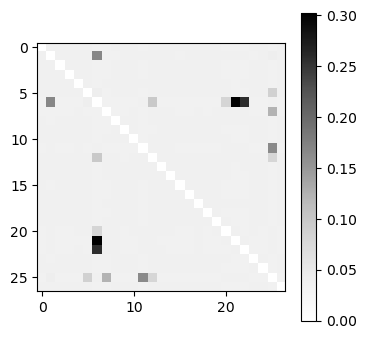

C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_4588\1497127798.py:9: RuntimeWarning: divide by zero encountered in divide
  G = nx.from_numpy_matrix(1 / A)


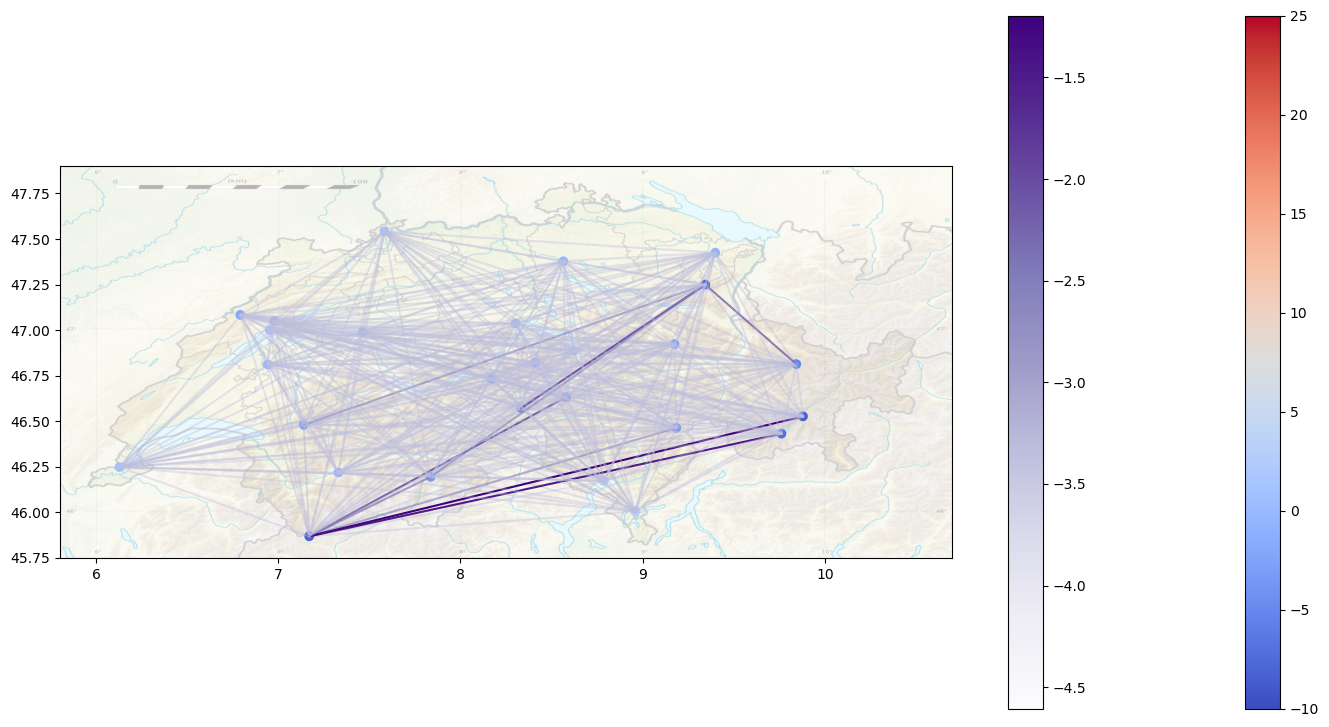

In [273]:
data_1965_1989_time = data_1965_1989.groupby("Station")

data_1965_1989_temp = np.array(
    data_1965_1989_time["Temperature"]
    .apply(lambda x: np.array(x.values.tolist()))
    .values.tolist()
).reshape(
    len(stations), -1, 12
)  # number of stations (27) x number of years (25) x months (12)

def topo_infer_time(data, N, alpha, beta, gamma, k=12):
    # M = k - 1 in the paper, R_list[i] is R_{k-1-i} in the paper
    R_list = [cp.Variable((N, N), symmetric=True) for _ in range(k-1)]
    # constraints = []
    constraints = [R >= 0 for R in R_list] #  + [cp.sum(R) == N for R in R_list]
    objective = cp.Minimize(cp.sum_squares(data[:, :, -1] - cp.sum([R_list[i] @ data[:, :, i] for i in range(k-1)], axis=2)) + alpha * cp.sum([cp.sum(cp.abs(R)) for R in R_list]))
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=True)
    R_list_0 = [R.value for R in R_list]

    A = cp.Variable((N, N), symmetric=True)
    constraints = [A >= 0, cp.sum(A) >= N, cp.diag(A) == 0]
    # constraints = [A >= 0, cp.diag(A) == 0]
    objective = cp.Minimize(cp.sum_squares(R_list_0[-1] - A) + gamma * cp.sum(A) + beta * cp.sum([cp.sum_squares(A @ R - R @ A) for R in R_list_0[:-1]]))
    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=True)

    A_power_list = [np.linalg.matrix_power(A.value, i) for i in range(k)]

    # C_list[i] is C_{k-1-i} in the paper
    C_list = [cp.Variable(k-i) for i in range(k-1)]
    for i in range(k-1):
        C = C_list[i]
        # constraints = [cp.sum(cp.abs(C)) >= 1]
        constraints = []
        objective = cp.Minimize(cp.sum_squares(R_list_0[i] - cp.sum([C[j] * A_power_list[j] for j in range(k-i)])) + gamma * cp.norm(C, 1))
        prob = cp.Problem(objective, constraints)
        prob.solve(verbose=True)

    return np.array(R_list_0), A.value, [C.value for C in C_list]

R_list, A, C_list = topo_infer_time(data_1965_1989_temp, N, 5, 0.01, 0.001)
print(A)

plt.figure(figsize=(4, 4))
plt.imshow(A, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 9))
ax1 = plt.subplot(1, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], graph_sparsify(-A), N, 0.01, img)

plt.show()


(11, 27, 27)
(27, 25, 12)


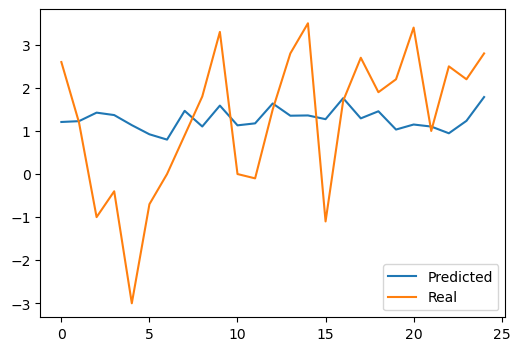

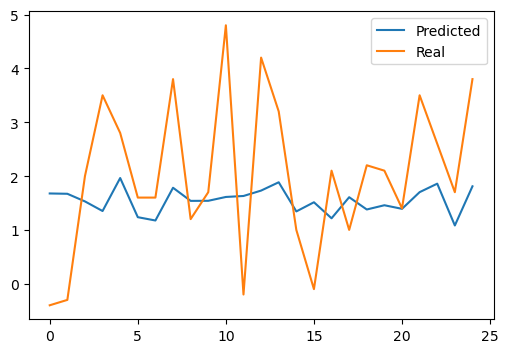

In [270]:
print(R_list.shape)
print(data_1965_1989_temp.shape)
pred = np.einsum("ijk, kmi -> jm", R_list, data_1965_1989_temp[:, :, :-1])
real = data_1965_1989_temp[:, :, -1] # 27x25

plt.figure(figsize=(6, 4))
plt.plot(pred[0, :], label="Predicted")
plt.plot(real[0, :], label="Real")
plt.legend()
plt.show()

data_1990_2014 = df_all[(df_all["Year"] >= 1990) & (df_all["Year"] < 2015)]
data_1990_2014_time = data_1990_2014.groupby("Station")
data_1990_2014_temp = np.array(
    data_1990_2014_time["Temperature"]
    .apply(lambda x: np.array(x.values.tolist()))
    .values.tolist()
).reshape(
    len(stations), -1, 12
)
pred_test = np.einsum("ijk, kmi -> jm", R_list, data_1990_2014_temp[:, :, :-1])
real_test = data_1990_2014_temp[:, :, -1]

plt.figure(figsize=(6, 4))
plt.plot(pred_test[0, :], label="Predicted")
plt.plot(real_test[0, :], label="Real")
plt.legend()
plt.show()

(11, 27, 27)
(27, 25, 11)


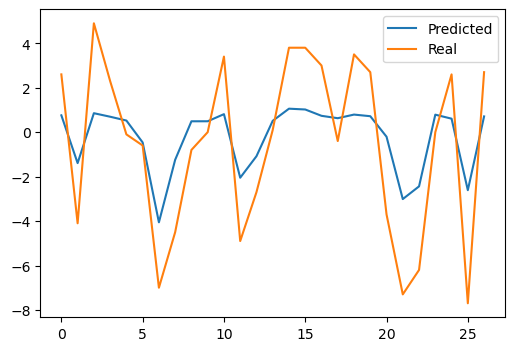

(27, 1)
(27, 25)


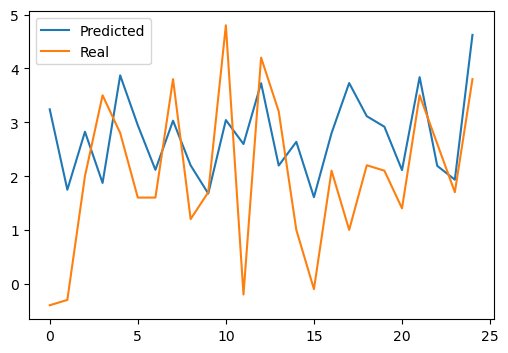

In [272]:
k = 12
A_power_list = [np.linalg.matrix_power(A, i) for i in range(k)]
R_list_A = np.array([np.sum([C_list[i][j] * A_power_list[j] for j in range(k-i)], axis=0) for i in range(k-1)])
print(R_list_A.shape)
print(data_1965_1989_temp[:, :, :-1].shape)

pred_new = np.einsum("ijk, kmi -> jm", R_list_A, data_1965_1989_temp[:, :, :-1])

plt.figure(figsize=(6, 4))
plt.plot(pred_new[:, 0], label="Predicted")
plt.plot(real[:, 0], label="Real")
plt.legend()
plt.show()

b = np.mean(real - pred_new, axis=1).reshape(-1, 1)
print(b.shape)
b = np.zeros((N, 1))

pred_test_new = np.einsum("ijk, kmi -> jm", R_list_A, data_1990_2014_temp[:, :, :-1]) + b
print(pred_test_new.shape)

plt.figure(figsize=(6, 4))
plt.plot(pred_test_new[0, :], label="Predicted")
plt.plot(real_test[0, :], label="Real")
plt.legend()
plt.show()